# Create footfall predictor model for given sensor

This notebook goes throught the steps for producing a model that predicts footfall for the next hourly timestep. Data can only be extracted from one sensor, which must have full data without missing gaps. Therefore, any model produced from this notebook is a prediction tool for the sensor it was trained on. There is a routine in the below code which check the available sensors that have no missing gaps.

In [63]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

import sklearn
from sklearn.inspection import permutation_importance

from sklearn.utils import class_weight

import os
import numpy as np

from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Embedding, Masking, Bidirectional
from keras.optimizers import Adam

from keras.utils import plot_model

from datetime import datetime
from datetime import timedelta


## Load and prepare the data

In [64]:
def prepare_x_y_data(input_csv):
    # Read in formatted data
    data = pd.read_csv(input_csv, index_col = False)
    data = data.fillna(0)
    
    ### Delete unneeded columns - we currently include data from all sensors (even incomplete ones)
    sensor_ids = data['sensor_id']
    #data = data.drop(['sensor_id'],axis=1) # don't want this included
    # Get rid of columns in which none of the sensors have a value
    for column in data.columns:
        if np.nanmax(data[column]) ==0:
            del data[column]
            
    # Filter columns using the regex pattern in function input
    regex_pattern = 'buildings$|street_inf$|landmarks$'
    data = data[data.columns.drop(list(data.filter(regex=regex_pattern)))].copy()
    
    ### Add a random variable (to compare performance of other variables against)
    rng = np.random.RandomState(seed=42)
    data['random'] = np.random.random(size=len(data))
    data["random_cat"] = rng.randint(3, size=data.shape[0])
    
    ## Prepare data for modelling 
    ### Split into predictor/predictand variables
    Xfull = data.drop(['hourly_counts'], axis =1)
    Yfull = data['hourly_counts'].values
       
    ### Store the (non Sin/Cos) time columns and then remove them (Need them later to segment the results by hour of the day)
    data_time_columns = Xfull[['day_of_month_num', 'time', 'weekday_num', 'time_of_day', 'datetime']]
    #Xfull = Xfull.drop(['day_of_month_num', 'time', 'weekday_num', 'time_of_day','datetime', 'month_num'],axis=1)
    Xfull = Xfull.drop(['day_of_month_num', 'time', 'weekday_num', 'time_of_day', 'month_num'],axis=1)
    return Xfull, Yfull, data_time_columns

In [65]:
def normalize(df, target_column):
    
    result = df.copy()
    
    for feature_name in df.columns:
        
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        
        if feature_name == 'footfall':
            result['footfall_norm'] = (df[feature_name] - min_value) / (max_value - min_value)
            
        else:
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    
    cols = list(result.columns)
    column_list = cols[:-2] + cols[-1:] + cols[-2:-1]
    result = result[column_list]
    
    return result

In [66]:
buffer_size_m = 400
input_csv ="/lustre_scratch/eejasm/DUST/formatted_data_for_modelling_allsensors_{}.csv".format(buffer_size_m)

X_data, Y_data, data_time_columns = prepare_x_y_data(input_csv)

X_data = X_data.iloc[:2198889]
Y_data = Y_data[:2198889]
data_time_columns = data_time_columns.iloc[:2198889]

In [67]:
# Find the sensors that have continuous data throughout the time period (no hourly gaps)

sensor_and_date = X_data.iloc[:,:2]
for _id in set(sorted(sensor_and_date['sensor_id'])):
    
    datetimes = list(sensor_and_date.loc[sensor_and_date['sensor_id']== _id, 'datetime'])
    empty_list = []
    
    for i in range(len(datetimes)-1):
        if datetime.strptime(datetimes[i+1], "%Y-%m-%d %H:%M:%S") != datetime.strptime(datetimes[i], "%Y-%m-%d %H:%M:%S") + timedelta(hours=1):
            empty_list.append(1)
            break
    
    if sum(empty_list) < 1:
        print(_id)
           

49
51
54


In [68]:
# choose one sensor to train the model on
sensor_id = 54
X_data = X_data.loc[X_data['sensor_id'] == sensor_id]
Y_data = Y_data[X_data.loc[X_data['sensor_id'] == sensor_id].index]
data_time_columns = data_time_columns.iloc[X_data.loc[X_data['sensor_id'] == sensor_id].index]

In [69]:
# make a copy of the data to combine X and Y
df = X_data.copy()
df['footfall'] = Y_data

# extraxt max values for normalization
footfall_max = df['footfall'].max()
footfall_min = df['footfall'].min()

In [70]:
# split into train, val and test sets
n=len(df)

train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

In [71]:
# choose the features to include as predictors
features = ['footfall']

train_df = train_df.loc[:, features]
val_df = val_df.loc[:, features]
test_df = test_df.loc[:, features]

In [72]:
# normalize and drop na fields
train_df = normalize(train_df, 'footfall')
val_df = normalize(val_df, 'footfall')
test_df = normalize(test_df, 'footfall')

train_df = train_df.dropna(axis='columns')
val_df = val_df.dropna(axis='columns')
test_df = test_df.dropna(axis='columns')

## Time series forecasting

In [73]:
# create a window generator that generates windows of data for input into model training
# also has a plotting routine to check the results

class WindowGenerator():
    def __init__(self, input_width, label_width, shift, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=None):
        
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
    
        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        
        self.column_indices = {name: i for i, name in
                            enumerate(train_df.columns)}
    
        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
    
        self.total_window_size = input_width + shift
    
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
    
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
    def split_window(self, features):
        
        inputs = features[:, self.input_slice, -1:]
        labels = features[:, self.labels_slice, :]
        #print(inputs.shape)
        #inputs[:,:,-1] = (inputs[:,:,-1] - footfall_min) / (footfall_max - footfall_min)

        
        if self.label_columns is not None:
            labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns],axis=-1)
    
        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
    
        return inputs, labels
    
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)
        ds = ds.map(self.split_window)
        return ds
    
    # a plot function to view a few examples of how the footfall prediction compares to the observed value
    def plot(self, model=None, plot_col='footfall', max_subplots=10):
    
        inputs, labels = self.example
        plt.figure(figsize=(12, 18))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        print(max_n)
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index-1],
                     label='Inputs', marker='.', zorder=-10)
        
            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index
        
            if label_col_index is None:
                continue
        
            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n,label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=64)
        
            if n == 0:
                plt.legend()
        
        plt.xlabel('Time [h]')


In [74]:
# set epochs and function for compile/training the model
MAX_EPOCHS = 200

def compile_and_fit(model, window, patience=3):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping],
                       verbose=1)
    return history

In [75]:
# setup window with required parameters
w2 = WindowGenerator(input_width=6, label_width=1, shift=1, label_columns=['footfall'])

In [76]:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

In [77]:
# set to check output looks correct
example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 2)
Inputs shape: (3, 6, 1)
Labels shape: (3, 1, 1)


In [78]:
# the WindowGenerator object holds training, validation, and test data. 
# Here we add properties for accessing them as tf.data.Datasets using the make_dataset method we defined earlier

@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [79]:
# check each batch before going into training
for example_inputs, example_labels in w2.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 1)
Labels shape (batch, time, features): (32, 1, 1)


In [80]:
# setup the LSTM model
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [82]:
# train the model
history = compile_and_fit(lstm_model, w2)

Epoch 1/200
136/136 [==============================] - 2s 6ms/step - loss: 50662.6055 - mean_absolute_error: 162.4309 - val_loss: 13434.4502 - val_mean_absolute_error: 84.8543
Epoch 2/200
136/136 [==============================] - 1s 4ms/step - loss: 47612.1367 - mean_absolute_error: 154.7360 - val_loss: 12225.1973 - val_mean_absolute_error: 80.0788
Epoch 3/200
136/136 [==============================] - 1s 4ms/step - loss: 45838.2109 - mean_absolute_error: 150.8571 - val_loss: 11480.0674 - val_mean_absolute_error: 77.1251
Epoch 4/200
136/136 [==============================] - 0s 4ms/step - loss: 44454.1406 - mean_absolute_error: 147.6103 - val_loss: 10834.1602 - val_mean_absolute_error: 74.1137
Epoch 5/200
136/136 [==============================] - 1s 4ms/step - loss: 43209.9102 - mean_absolute_error: 144.5434 - val_loss: 10251.5762 - val_mean_absolute_error: 71.5084
Epoch 6/200
136/136 [==============================] - 1s 5ms/step - loss: 42034.5703 - mean_absolute_error: 141.6853 - 

## Results

10


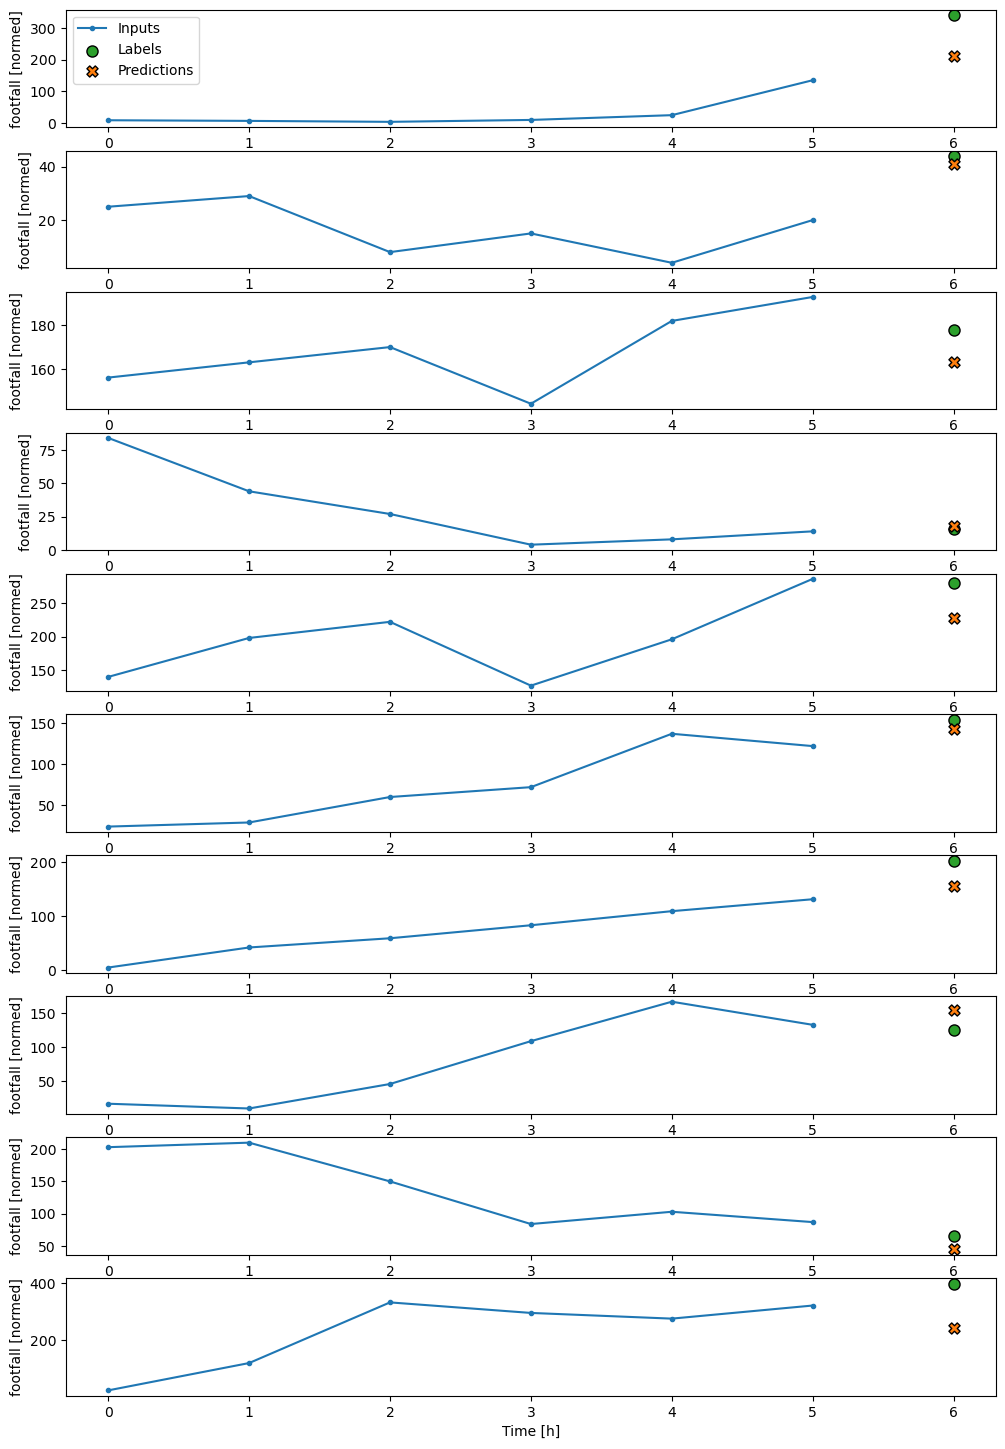

In [87]:
# produce some qualitative results
w2.plot(lstm_model)

In [86]:
# produce some quantitativbe statistics
val_performance['LSTM'] = lstm_model.evaluate(w2.val)
performance['LSTM'] = lstm_model.evaluate(w2.test, verbose=1)

val_mean_absolute_error = val_performance['LSTM'][1]
print('Mean absolute error:', val_mean_absolute_error)

test_mean_absolute_error = performance['LSTM'][1]
print('Mean absolute error:', test_mean_absolute_error)

20/20 [==============================] - 0s 2ms/step - loss: 24743.1641 - mean_absolute_error: 89.1932
Mean absolute error: 26.844907760620117
Mean absolute error: 89.19316864013672


In [148]:
# save the model
lstm_model.save('sensor_54_window_6_model')

INFO:tensorflow:Assets written to: sensor_54_window_6_model/assets


INFO:tensorflow:Assets written to: sensor_54_window_6_model/assets
